1. Obtention des données

In [1]:
from sklearn.datasets import fetch_kddcup99
import pandas as pd

# Charger les données
data = fetch_kddcup99(subset=None, shuffle=True, percent10=True, as_frame=True)

# Convertir en DataFrame
df = data.frame
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,b'udp',b'ntp_u',b'SF',48,48,0,0,0,0,...,28,0.29,0.03,0.29,0.0,0.0,0.0,0.0,0.0,b'normal.'
1,0,b'udp',b'private',b'SF',105,145,0,0,0,0,...,227,0.89,0.01,0.0,0.0,0.0,0.0,0.0,0.0,b'normal.'
2,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,b'smurf.'
3,0,b'tcp',b'private',b'S0',0,0,0,0,0,0,...,8,0.03,0.08,0.0,0.0,1.0,1.0,0.0,0.0,b'neptune.'
4,0,b'icmp',b'ecr_i',b'SF',520,0,0,0,0,0,...,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,b'smurf.'


2. Exploration des données

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   duration                     494021 non-null  object
 1   protocol_type                494021 non-null  object
 2   service                      494021 non-null  object
 3   flag                         494021 non-null  object
 4   src_bytes                    494021 non-null  object
 5   dst_bytes                    494021 non-null  object
 6   land                         494021 non-null  object
 7   wrong_fragment               494021 non-null  object
 8   urgent                       494021 non-null  object
 9   hot                          494021 non-null  object
 10  num_failed_logins            494021 non-null  object
 11  logged_in                    494021 non-null  object
 12  num_compromised              494021 non-null  object
 13  root_shell    

In [3]:
df.describe()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
count,494021,494021,494021,494021,494021,494021,494021,494021,494021,494021,...,494021,494021.0,494021.0,494021.0,494021.0,494021.0,494021.0,494021.0,494021.0,494021
unique,2495,3,66,11,3300,10725,2,3,4,22,...,256,101.0,101.0,101.0,65.0,100.0,72.0,101.0,101.0,23
top,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,b'smurf.'
freq,481671,283602,281400,378440,228035,408258,493999,492783,494017,490829,...,337746,347828.0,347031.0,288883.0,441889.0,399810.0,400945.0,458792.0,459805.0,280790


In [5]:
df['labels'].value_counts()

,count
labels,
b'smurf.',280790
b'neptune.',107201
b'normal.',97278
b'back.',2203
b'satan.',1589
b'ipsweep.',1247
b'portsweep.',1040
b'warezclient.',1020
b'teardrop.',979


**Comprendre les attributs et comment ils peuvent servir de fonctionnalités pour la détection d’anomalies. Pouvez-vous déjà repérer des anomalies en visualisant les données ?**

Quelques exemples d'atribut qui peuvent servir pour la détection d'anomalie :

duration : durée de la connexion → Une connexion anormalement longue ou courte peut être suspecte.

service : service réseau utilisé (HTTP, FTP, SMTP, etc.) → Certains services sont plus vulnérables aux attaques.

count : nombre de connexions dans un certain laps de temps → Une activité excessive d’une même adresse IP peut être suspecte.

dst_host_same_srv_rate : pourcentage de connexions vers le même service → Une forte répétition peut signaler un scan de service.

3. Construction et évaluation d'un détecteur d'anomalies.

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encoder les colonnes catégorielles
for col in ['protocol_type', 'service', 'flag']:
    df[col] = LabelEncoder().fit_transform(df[col])


In [12]:
X = df.drop(columns=['labels'])  # Supprimer la colonne cible
y = df['labels'].apply(lambda x: 1 if x == b'normal.' else -1)  # Normal = 1, Anomalie = -1

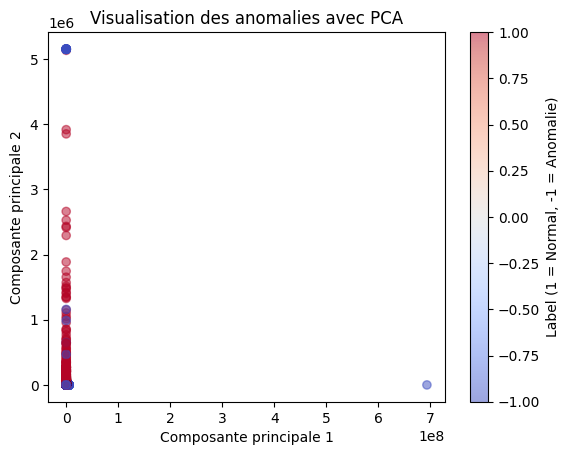

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Réduction en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.title('Visualisation des anomalies avec PCA')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Label (1 = Normal, -1 = Anomalie)')
plt.show()


In [9]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X)

# Prédictions
y_pred = iso_forest.predict(X)


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Précision :", precision_score(y, y_pred, pos_label=-1))
print("Rappel :", recall_score(y, y_pred, pos_label=-1))
print("F1-score :", f1_score(y, y_pred, pos_label=-1))


Précision : 0.5978502894619651
Rappel : 0.07444365748103936
F1-score : 0.13240090105234845
